In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, welch
from utils import cut_bvp
from constants import Timestamps, expressive


In [44]:
base_path_video = "BVPs"

failed_masks = [
    [2, "Q1_1"],
    [52, "Q7_2"],
    [53, "Q4_2"]
]

paths = [
    "Q1_1",
    "Q1_2",
    # "Q2_1",
    # "Q2_2",
    # "Q3_1",
    # "Q3_2",
    # "Q4_1",
    # "Q4_2",
    # "Q5_1",
    # "Q5_2",
    # "Q6_1",
    # "Q6_2",
    # "Q7_1",
    # "Q7_2",
    # "Q8_1",
    # "Q8_2",
    "Q9_1",
    "Q9_2"
]

patients = list(range(1, 62))
patients.remove(23)

#patients = expressive

In [45]:
class BVP:
    def __init__(self, patient, path, signal, features):
        self.patient = patient
        self.path = path
        self.signal = signal
        self.features = features

In [46]:
#Test timestamps
for path in paths:

    t_start, t_end = getattr(Timestamps, path)

    print(t_start, t_end, "...........", t_end - t_start)

14 19 ........... 5
24 29 ........... 5
15 20 ........... 5
13 18 ........... 5


In [47]:
fs = 60

BVPs = []

for patient in patients:

    for path in paths:

        if [patient, path] in failed_masks:
            print(f"Skipping Patient_{patient}, {path}")
            continue

        data = np.load(f"{base_path_video}/Patient_{patient}/{path}.npy")

        t_start, t_end = getattr(Timestamps, path)

        data_cut = cut_bvp(data, t_start, t_end, fs)

        bvp = BVP(patient, path, data_cut, [])

        BVPs.append(bvp)

        #print(f"Patient_{patient}, {path}: {data.shape}")

print(f"Loaded {len(BVPs)} BVP signals")

Skipping Patient_2, Q1_1
Loaded 239 BVP signals


In [48]:
def get_peaks(bvp, fs):
    """
    Detect heart beats from BVP.
    distance ensures physiological HR range.
    """
    peaks, _ = find_peaks(
        bvp,
        distance=int(fs * 0.4)  # max 150 bpm
    )
    return peaks


In [49]:
def time_domain_features(bvp, fs):
    peaks = get_peaks(bvp, fs)

    if len(peaks) < 2:
        return None

    # RR intervals (seconds)
    rr = np.diff(peaks) / fs

    features = {}

    # Heart Rate
    features["HR_mean"] = 60 / np.mean(rr)
    features["HR_std"]  = np.std(60 / rr)

    # HRV features
    features["RMSSD"] = np.sqrt(np.mean(np.diff(rr) ** 2))
    features["SDNN"]  = np.std(rr)

    # pNN50
    features["pNN50"] = np.sum(np.abs(np.diff(rr)) > 0.05) / len(rr)

    return features


In [50]:
def frequency_domain_features(bvp, fs):
    peaks = get_peaks(bvp, fs)

    if len(peaks) < 4:
        print("Too small:", len(peaks))
        return None

    rr = np.diff(peaks) / fs
    rr_times = np.cumsum(rr)

    # Interpolate RR series
    rr_interp_time = np.linspace(rr_times[0], rr_times[-1], len(rr))
    rr_interp = np.interp(rr_interp_time, rr_times, rr)

    freqs, psd = welch(rr_interp, fs=4.0)

    lf_band = (freqs >= 0.04) & (freqs < 0.15)
    hf_band = (freqs >= 0.15) & (freqs < 0.4)

    lf = np.trapezoid(psd[lf_band], freqs[lf_band])
    hf = np.trapezoid(psd[hf_band], freqs[hf_band])

    features = {
        "LF": lf,
        "HF": hf,
        "LF_HF": lf / hf if hf > 0 else 0
    }

    return features


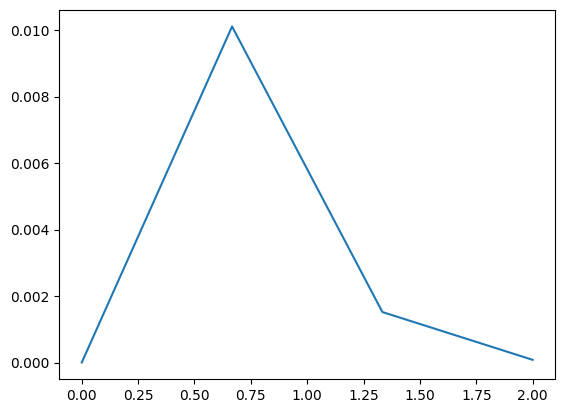

In [51]:
bvp, fs = BVPs[0].signal, 60

peaks = get_peaks(bvp, fs)

if len(peaks) < 4:
    print("Too small:", len(peaks))

rr = np.diff(peaks) / fs
rr_times = np.cumsum(rr)

# Interpolate RR series
rr_interp_time = np.linspace(rr_times[0], rr_times[-1], len(rr))
rr_interp = np.interp(rr_interp_time, rr_times, rr)

freqs, psd = welch(rr_interp, fs=4.0)

plt.plot(freqs, psd)

lf_band = (freqs >= 0.04) & (freqs < 0.15)
hf_band = (freqs >= 0.15) & (freqs < 0.4)

lf = np.trapezoid(psd[lf_band], freqs[lf_band])
hf = np.trapezoid(psd[hf_band], freqs[hf_band])

features = {
    "LF": lf,
    "HF": hf,
    "LF_HF": lf / hf if hf > 0 else 0
}

In [52]:
def morphological_features(bvp, fs):
    peaks = get_peaks(bvp, fs)

    if len(peaks) < 2:
        return None

    amplitudes = bvp[peaks]

    features = {
        "Pulse_amp_mean": np.mean(amplitudes),
        "Pulse_amp_std":  np.std(amplitudes)
    }

    return features


In [53]:
def extract_features_from_bvp(bvp, fs):
    feats = {}

    td = time_domain_features(bvp, fs)
    #fd = frequency_domain_features(bvp, fs)
    md = morphological_features(bvp, fs)

    if td is None or md is None: #or fd is None
        return None

    feats.update(td)
    #feats.update(fd)
    feats.update(md)

    return feats


In [64]:
fs = 60

valid = []

failed = []

failed_masks = [
    [2, "Q1_1"],
    [52, "Q7_2"],
    [53, "Q4_2"]
]

for bvp in BVPs:
    
    feats = extract_features_from_bvp(bvp.signal, fs)

    if feats is None or []:
        # Do nothing
        print(f"Failed: Patient_{bvp.patient}, {bvp.path}")
        BVPs.remove(bvp)
        continue
    
    bvp.features = feats

    valid.append(f"Patient_{bvp.patient}, {bvp.path}")

print(f"Extracted features for {len(valid)} videos")


Extracted features for 238 videos


In [65]:
label_map = {
    "Q1": 1,
    "Q2": 1,
    "Q3": 1,
    "Q4": 0,
    "Q5": 0, 
    "Q6": 0,
    "Q7": -1,
    "Q8": -1,
    "Q9": -1
}

def get_label(path):
    q = path.split("_")[0]  # "Q3_2" → "Q3"
    return label_map[q]



In [67]:
for bvp in BVPs:

    try: 

        for feat, val in bvp.features.items():
            #print(feat, val)
            i = 1
        #print(bvp.patient, bvp.path, "Success")

    except Exception as e:
        print(bvp.patient, bvp.path, e)


In [62]:
# import numpy as np

# X = []
# y = []

# for bvp in BVPs:
#     if bvp is None or bvp.features is []:
#         print("Error: Patient", bvp.patient, bvp.path)
#         continue

#     feat_values = list(bvp.features.values())
#     X.append(feat_values)
#     y.append(get_label(bvp.path))
    

# X = np.array(X)
# y = np.array(y)

# print(X.shape, y.shape)
# print(np.unique(y, return_counts=True))
# print("Example of data: ", X[0])


LEARNING

In [63]:
# # Random Split

#from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(
#     X, y,
#     test_size=0.2,
#     stratify=y,      # important for emotions
#     random_state=42
# )

# print(X_train.shape, y_train.shape)
# print(X_test.shape, y_test.shape)

# print("Example of data: ", X_train[0])


In [70]:
# Expressive for test


X_train = []
y_train = []

X_test = []
y_test = []

for bvp in BVPs:
    if bvp is None or bvp.features is []:
        print("Fatal Error: Patient", bvp.patient, bvp.path)
        continue

    elif bvp.patient in expressive:
        #print(bvp.patient, bvp.path, "EXPRESSIVE")
        X_train.append(list(bvp.features.values()))
        y_train.append(get_label(bvp.path))

    else:
        #print(bvp.patient, bvp.path, bvp.features, "REST")
        X_test.append(list(bvp.features.values()))
        y_test.append(get_label(bvp.path))

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)


print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

print("Example of data: ", X_train[0])

(80, 7) (80,)
(158, 7) (158,)
Example of data:  [8.74493927e+01 3.05153999e+01 2.40601099e-01 1.81408243e-01
 5.00000000e-01 1.21906164e-01 8.70925070e-02]


In [71]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)


In [ ]:
# from sklearn.linear_model import LogisticRegression

# clf = LogisticRegression(
#     max_iter=1000,
#     class_weight="balanced"  # helpful for imbalance
# )

# clf.fit(X_train, y_train)


LogisticRegression(class_weight='balanced', max_iter=1000)

In [72]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight="balanced"
)

clf.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', n_estimators=200,
                       random_state=42)

In [73]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

          -1       0.47      0.47      0.47        80
           1       0.46      0.46      0.46        78

    accuracy                           0.47       158
   macro avg       0.47      0.47      0.47       158
weighted avg       0.47      0.47      0.47       158

[[38 42]
 [42 36]]


In [74]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(
    clf, X, y,
    cv=cv,
    scoring="f1_macro"
)

print("F1 macro:", scores.mean(), "±", scores.std())


F1 macro: 0.4371367521367522 ± 0.12786410484652705


In [75]:
import pandas as pd

feature_names = list(BVPs[0].features.keys())

importances = clf.feature_importances_
imp_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

print(imp_df)


          feature  importance
0         HR_mean    0.178254
5  Pulse_amp_mean    0.152898
3            SDNN    0.151028
6   Pulse_amp_std    0.143142
1          HR_std    0.142027
2           RMSSD    0.124515
4           pNN50    0.108135
